In [63]:
# imports 
import pandas as pd 
import numpy as np 

# visualizations
import matplotlib.pyplot as plt 
from matplotlib import style 
%matplotlib inline 
import seaborn as sns 
style.use('fivethirtyeight')

# modeling 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [6]:
!ls data

2022_NYS_grad-rate.csv


In [7]:
# importing our data 
nys_gradrate_22 = pd.read_csv('data/2022_NYS_grad-rate.csv')

In [10]:
# reformating some column names
nys_gradrate_22 = nys_gradrate_22.rename(
    columns={'entity_cd':'beds_cd','entity_name':'school','subgroup_name':'subgroup'})

In [60]:
# looking at our data
nys_gradrate_22.head()

,beds_cd,school,year,subgroup,grad_rate
0,10100010034,Albany High School,2022,Hispanic or Latino,73.7
1,10100010034,Albany High School,2022,White,86.9
2,10100010034,Albany High School,2022,Multiracial,77.4
3,10100010034,Albany High School,2022,English Language Learner,70.4
4,10100010034,Albany High School,2022,Economically Disadvantaged,75.5


### ANOVA (Analysis of Variance) Between Schools 

ANOVA ("Analysis of Variance") is a statistical test used to determine whether there is **statistically significant difference** of an outcome (i.e., graduation rates) between three or more groups. 

In [18]:
import researchpy as rp

In [16]:
nys_gradrate_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   beds_cd    4680 non-null   int64  
 1   school     4680 non-null   object 
 2   year       4680 non-null   int64  
 3   subgroup   4680 non-null   object 
 4   grad_rate  4680 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 182.9+ KB


In [19]:
rp.summary_cont(nys_gradrate_22.grad_rate)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,grad_rate,4680.0,85.0974,14.3692,0.21,84.6856,85.5092


In [21]:
rp.summary_cont(nys_gradrate_22['grad_rate'].groupby(nys_gradrate_22['subgroup']))

,N,Mean,SD,SE,95% Conf.,Interval
subgroup,,,,,,
American Indian or Alaska Native,15,82.0200,15.4433,3.9874,73.4678,90.5722
Asian or Native Hawaiian/Other Pacific Islander,272,95.6239,6.5690,0.3983,94.8397,96.4081
Black or African American,631,85.6162,14.7571,0.5875,84.4625,86.7698
Economically Disadvantaged,1166,85.0009,13.2655,0.3885,84.2387,85.7631
English Language Learner,270,70.9196,14.4079,0.8768,69.1933,72.6460
Hispanic or Latino,742,84.1911,14.9841,0.5501,83.1112,85.2710
Multiracial,54,89.1148,10.2780,1.3987,86.3095,91.9202
Students with Disabilities,748,78.1086,15.2341,0.5570,77.0151,79.2021
White,782,93.3832,6.3253,0.2262,92.9392,93.8273


In [23]:
import scipy.stats as stats

In [43]:
# conducting a one-way ANOVA between student subgroups and graduation rates
stats.f_oneway(nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='American Indian or Alaska Native'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Asian or Native Hawaiian/Other Pacific Islander'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Black or African American'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Economically Disadvantaged'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='English Language Learner'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Hispanic or Latino'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Multiracial'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='Students with Disabilities'],
nys_gradrate_22['grad_rate'][nys_gradrate_22['subgroup']=='White'],)

F_onewayResult(statistic=130.45973071336795, pvalue=3.696850480067743e-198)

In [44]:
from statsmodels.formula.api import ols 

In [47]:
subgroup_lm = ols('grad_rate ~ C(subgroup)', nys_gradrate_22).fit()

In [48]:
aov_results = sm.stats.anova_lm(subgroup_lm,typ=2)
aov_results

,sum_sq,df,F,PR(>F)
C(subgroup),176439.445105,8.0,130.459731,3.696850e-198
Residual,789658.084126,4671.0,NaN,NaN


In [49]:
school_lm = ols('grad_rate ~ C(school)', nys_gradrate_22).fit()

In [57]:
aov_results2 = sm.stats.anova_lm(school_lm, typ=1)
aov_results2

,df,sum_sq,mean_sq,F,PR(>F)
C(school),1239.0,748158.585707,603.840666,9.531164,0.0
Residual,3440.0,217938.943524,63.354344,NaN,NaN


### Linear Mixed Effects Model 

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
# linear mixed effects on entire dataset -- no train-test split 
md = smf.mixedlm("grad_rate ~ subgroup", nys_gradrate_22, groups=nys_gradrate_22["school"])
mdf = md.fit()
print(mdf.summary())

                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                grad_rate  
No. Observations:                  4680                   Method:                            REML       
No. Groups:                        1240                   Scale:                             35.3361    
Min. group size:                   1                      Log-Likelihood:                    -16645.1300
Max. group size:                   12                     Converged:                         Yes        
Mean group size:                   3.8                                                                  
--------------------------------------------------------------------------------------------------------
                                                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------

In [15]:
# schools as groups 

md = smf.mixedlm("grad_rate ~ school", nys_gradrate_22, groups=nys_gradrate_22["subgroup"])
mdf = md.fit()
print(mdf.summary())

                            Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             grad_rate  
No. Observations:             4680                Method:                         REML       
No. Groups:                   9                   Scale:                          35.3582    
Min. group size:              15                  Log-Likelihood:                 -11789.0100
Max. group size:              1166                Converged:                      Yes        
Mean group size:              520.0                                                          
---------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------
Intercept                                       79.032    3.115  25.374 0.000  72.927  8

## Testing TrTs-Split on Mixed Effect 

**Fixed Effect** == graduation rates 

**Random Effects** == school + student subgroup

In [99]:
# splitting data 
X = nys_gradrate_22.drop(columns=['beds_cd','year'])

X_train, X_test = train_test_split(X, test_size=0.2)

In [124]:
# linear mixed effect with 
md_1 = smf.mixedlm("grad_rate ~subgroup", X_train, groups= X_train["school"])
mdf_1 = md_1.fit()
print(mdf_1.summary())

                                 Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                grad_rate  
No. Observations:                  3744                   Method:                            REML       
No. Groups:                        1219                   Scale:                             35.7151    
Min. group size:                   1                      Log-Likelihood:                    -13515.3805
Max. group size:                   9                      Converged:                         Yes        
Mean group size:                   3.1                                                                  
--------------------------------------------------------------------------------------------------------
                                                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------

In [106]:
# getting our predictions 
preds = mdf.predict(X_test)

# evaluating based on MAE 
mean_absolute_error(X_test.grad_rate,preds.values)

In [121]:
mdf_1.pvalues

Intercept                                                      0.000000e+00
subgroup[T.Asian or Native Hawaiian/Other Pacific Islander]    2.719429e-03
subgroup[T.Black or African American]                          4.933290e-01
subgroup[T.Economically Disadvantaged]                         7.039425e-01
subgroup[T.English Language Learner]                           5.057406e-10
subgroup[T.Hispanic or Latino]                                 4.812671e-01
subgroup[T.Multiracial]                                        3.327953e-01
subgroup[T.Students with Disabilities]                         1.540731e-04
subgroup[T.White]                                              4.584772e-03
Group Var                                                      4.271603e-76
dtype: float64

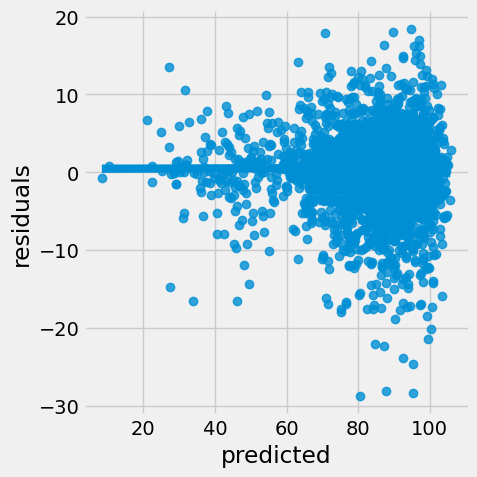

In [134]:
#
grad_rates_22 = pd.DataFrame()
grad_rates_22["residuals"] = mdf_1.resid.values
#grad_rates_22["subgroup"] = X_test.subgroup
grad_rates_22["predicted"] = mdf_1.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = grad_rates_22,lowess=True)

In [135]:
predictions = mdf_1.fittedvalues

In [144]:
X_test.grad_rate.values.shape

(936,)

In [145]:
predictions.shape

(3744,)

In [139]:
RMSE = np.sqrt(((X_test.grad_rate.values-predictions)**2).values.mean())
results.loc[2] = ["Mixed", RMSE]
results

ValueError: operands could not be broadcast together with shapes (936,) (3744,) 